<a href="https://colab.research.google.com/github/Peckkie/AIprototype2022_kie/blob/main/OVRDT_AI_RUN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ▶️ Installation and import library

In [ ]:
import os
os.chdir('/content')

In [ ]:
!rm -r ./OV-RDT-Deployment

In [ ]:
!git clone https://github.com/Peckkie/OV-RDT-Deployment.git
os.chdir('/content/OV-RDT-Deployment')

Cloning into 'OV-RDT-Deployment'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 8), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
!pwd

/content/OV-RDT-Deployment


In [ ]:
!ls

README.md  requirements.txt  SVM  util	YOLOv5


In [ ]:
pip install -qr ./requirements.txt  

In [ ]:
# import for model
import json 
import pandas as pd
import numpy as np
from pathlib import Path
import PIL
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import cv2 
import torch
import tqdm

## ▶️ Check strip image function 

In [ ]:
# Load image to image folder
def load_img(RowKey, path):
    import urllib.request
    import os

    os.chdir(path)
    path_img = 'https://ovrdt.blob.core.windows.net/ovrdtpics/'+RowKey+'.png'
    filename = RowKey+'.jpg'
    try :
        urllib.request.urlretrieve(path_img, filename)
    except:
        not_.append(RowKey)
        print(filename, 'error in downloading image')
    return filename

def image_detection(confident, s_pth, bat_images):
    
    import json 
    import numpy as np
    from pathlib import Path
    import PIL
    from PIL import Image
    import torch
    import tqdm

    #Run inference Multiple
    path_model = './YOLOv5/ModelYOLOv5m-R1-OVRDT-last.pt'
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=path_model) # local model
    # device = torch.device('cuda:0')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)


    # Run batched inference with YOLOv5 and PyTorch Hub:
    ## bat_images >>> --** batched list of images **-- multiple images, s_pth == list(set(test_df.img_path))
    model.conf = confident # NMS confidence threshold
    model.iou = 0.50 # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 10
    ## Result 
    results = model(bat_images, size=640)  

    for i, j in zip(range(len(results.xyxy)), s_pth):
        if len(results.xyxy[i]) == 0 :
            results.xyxy[i] = torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], dtype=torch.float)
        table = results.pandas().xyxy[i]
        table['Path'] = s_pth
        table['image_id'] = i

    return table

#Get Predict Bbox to 1 row
#รวม prediction box ใน 1 image 
def get_one_pre(table) : 
    a = table.groupby(['image_id']).count()
    a = table.iloc[:,0]
    aa_ =[]
    for  i in  range(len(a)):
        aa = a[i]
        aa_.append(aa)
    name = sorted(list(set(table['image_id'])))

    fileName_, x1s_, y1s_, x2s_, y2s_, score_ = [], [], [], [], [], []
    for j in name:
        x1_, y1_, x2_, y2_, score = [], [], [], [], []
        fileName_.append(j)
        for i in range(len(table)):
            fileName = table['image_id'][i] 
            if fileName == j:
                x1_.append(table['xmin'][i])
                y1_.append(table['ymin'][i])
                x2_.append(table['xmax'][i])
                y2_.append(table['ymax'][i])
                score.append(table['confidence'][i])

        x1s_.append(x1_)
        y1s_.append(y1_)
        x2s_.append(x2_)
        y2s_.append(y2_)
        score_.append(score)
        
    result = {'fileName': table['Path'][0], 'pred_xmin': x1s_,'pred_ymin': y1s_,'pred_xmax': x2s_,'pred_ymax': y2s_, 'pred_score': score_}
    result = pd.DataFrame(result)

    result['pred_count'] = ''
    emp = list()
    for k in range(len(result)):
        if result['pred_score'][k][0] == 0.0:
            result.loc[result.index[k], 'pred_count'] = 0
        else:
            result.loc[result.index[k], 'pred_count'] = len(result['pred_score'][k])

    return result

#####################################
#----------- STEP 1: Completely OV-RDT Detection -----------
#####################################

#STEP 1: Completely OV-RDT Detection
def manage_predict_file(result):

    result_ = pd.DataFrame(result, columns=['path_filename', 'fileName', 'pred_xmin','pred_ymin','pred_xmax','pred_ymax', 'pred_score'])
    result_['pred_count'] = ""
    emp = list()
    for k in range(len(result_)):
        if result_['pred_score'][k][0] == 0.0:
            result_.loc[result_.index[k], 'pred_count'] = 0
        else:
            result_.loc[result_.index[k], 'pred_count'] = len(result_['pred_score'][k])
    return result_

def OVRDTdetection(data, save_path):
    import os
    import cv2
    from matplotlib import pyplot as plt

    ymin = 0.389985
    ymax = 0.589000
    xmin = 0.271307
    xmax = 0.780217

    point_bias = 0.03 # ----------** setting

    fileName = data['fileName'].tolist()
    pred_score = data['pred_score'].tolist()
    result = []
    path_crop = []

    res = data
    img_path = fileName[0]
    img_c = cv2.imread(img_path)
    i = 0
    for j in range(len(res['pred_xmin'].tolist()[i])):

        xmin_pre, ymin_pre, xmax_pre, ymax_pre = [res['pred_xmin'].tolist()[i][j], res['pred_ymin'].tolist()[i][j], res['pred_xmax'].tolist()[i][j], 
                                                  res['pred_ymax'].tolist()[i][j]]

        xmin_, ymin_, xmax_ , ymax_ = [abs((xmin_pre/img_c.shape[1])-xmin), abs((ymin_pre/img_c.shape[0])-ymin), 
                                       abs((xmax_pre/img_c.shape[1])-xmax), abs((ymax_pre/img_c.shape[0])-ymax)]

        img_crop = img_c[int(ymin_pre):int(ymax_pre), int(xmin_pre):int(xmax_pre)]
        fname = img_path.split('/')[-1]

        if (xmin_ < point_bias) & (xmax_ < point_bias) & (ymin_ < point_bias) & (ymax_ < point_bias) :  
            if j == 0:
                path_crop.append(save_path+fname)
                plt.imsave(os.path.join(save_path, fname), img_crop)
                result.append({'path_filename': img_path, 'fileName':fileName[j], 'pred_xmin': xmin_pre, 'pred_ymin': ymin_pre, 'pred_xmax': xmax_pre,
                               'pred_ymax': ymax_pre, 'pred_score': pred_score[j]})
            else:
                path_crop.append(save_path+fname)
                plt.imsave(os.path.join(save_path, fname), img_crop)
                result.append({'path_filename': img_path, 'fileName':fileName[j], 'pred_xmin': xmin_pre, 'pred_ymin': ymin_pre, 'pred_xmax': xmax_pre,
                               'pred_ymax': ymax_pre, 'pred_score': pred_score[j]})
        else:
            return []


    result = manage_predict_file(result)
    result['path_crop'] = path_crop
    return result


##▶️ Classify function 

In [ ]:
import cv2
import ipywidgets as wdg
import matplotlib.pyplot as plt
import pandas as pd

def extract_rgb(str_loc, image_path):
    h, w, _ = image_path.shape
    col, row = str_loc
    return image_path[int(float(row*h)),int(float(col*w)),:]

def function_rgb(location, image_path):
    import pandas as pd
    minr, ming, minb= list(), list(), list()
    for i in range(len(location)):
        pixval = extract_rgb(location[i], image_path)
        minr.append(pixval[2])
        ming.append(pixval[1])
        minb.append(pixval[0])
    return minr, ming, minb

def extract_rgb_location(location, location_name, image_path):
    import pandas as pd
    R, G, B  = [], [], []
    R, G, B = function_rgb(location, image_path)
    tb = {'R':R, 'G':G, 'B':B}
    df = pd.DataFrame(tb,columns = ['R', 'G', 'B'], dtype = int)
    
    # Outlier -----
    boxplot_ = plt.boxplot(df.transpose(), labels=['R', 'G', 'B'])
    plt.close()
    whiskers = [item.get_ydata()[1] for item in boxplot_['whiskers']]
    whis_down  = [whiskers[i] for i in range(0,6) if i%2 == 0]
    whis_top = [whiskers[i] for i in range(0,6) if i%2 != 0]

    col_names = ['R_outlier', 'G_outlier', 'B_outlier']
    col_df=list(df.columns)
    for i in range(len(col_names)):
        df[col_names[i]] = (df[col_df[i]] < whis_down[i])|(df[col_df[i]] > whis_top[i])

    df['Outlier_Dropping'] = (df['R_outlier'] == True) |(df['G_outlier'] == True) |(df['B_outlier'] == True) 
    df = df[df['Outlier_Dropping'] != True]
    df = df[col_df]
   
    #min max mean -----
    tb_des = df.describe()
    tb = tb_des[1:2].append(tb_des[3:4]).append(tb_des[7:8])
    tb['Locations'] = location_name
    return tb

def extract_rgb_image(locations, location_name, image_path):
    import pandas as pd
    df = pd.DataFrame(columns = ['R', 'G', 'B', 'Locations'])
    for i in range(len(locations)):
        location = locations[i]
        res = extract_rgb_location(location, location_name[i],  image_path)
        df = df.append(res)
    return df

def extract_rgb_df(data, path, locations, location_name):
    import cv2
    import pandas as pd
    fileName = data['fileName'].tolist()
    pred_xmin = data['pred_xmin'].tolist()
    pred_ymin = data['pred_ymin'].tolist()
    pred_xmax = data['pred_xmax'].tolist()
    pred_ymax = data['pred_ymax'].tolist()
    pred_score = data['pred_score'].tolist()
    pred_count = data['pred_count'].tolist()
    #------------
    TB = pd.DataFrame(columns = ['R', 'G', 'B', 'Locations', 'path_filename', 'fileName', 'pred_xmin', 'pred_ymin', 'pred_xmax', 'pred_ymax', 'pred_count'])
    for i in range(len(data)):
        #print(f'On processing.. .  [{i}]')             
        image_path = cv2.imread(path[i])
        res = extract_rgb_image(locations, location_name, image_path)
        #Keep
        res['path_filename'] = path[i]
        res['fileName'] = fileName[i]
        res['pred_xmin'] = pred_xmin[i] 
        res['pred_ymin'] = pred_ymin[i]
        res['pred_xmax'] = pred_xmax[i]
        res['pred_ymax'] = pred_ymax[i]
        res['pred_count'] = pred_count[i]

        TB = TB.append(res)
    return TB

In [ ]:
def Completely_OVRDT_Detection(res_df):
    import cv2
    import ipywidgets as wdg
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn import svm
    from sklearn.metrics import classification_report,confusion_matrix
    import os

    #load model
    import pickle
    filename = "./SVM/RF_Grading_class_pattern2_12345RDT_noBias_0.pkl"
    with open(filename, 'rb') as file:
        model_Grading = pickle.load(file)

    from util  import classify  #Call classify.py
    location_T, location_C, location_M, location_L, location_R = classify.locations()

    locations = [location_T, location_C, location_R, location_L, location_M]
    location_name = ['T', 'C', 'R', 'L', 'M']
    data = res_df
    path = list(data.path_crop)
    TB =extract_rgb_df(data, path, locations, location_name)

    #DATA
    X_datat = TB.iloc[:,0:3].to_numpy().reshape(len(set(TB['path_filename'])),45)

    #Predict
    y_pred = model_Grading.predict(X_datat)
    y_prob= model_Grading.predict_proba(X_datat)

    return int(y_pred), float(y_prob[0][int(y_pred)])

## ⏯ Calling function

In [ ]:
# from utils  import classify  #Call classify.py
# location_T, location_C, location_M, location_L, location_R = classify.locations()
os.chdir('/content/OV-RDT-Deployment')

In [ ]:
!pwd

/content/OV-RDT-Deployment


In [ ]:
!ls

README.md  requirements.txt  SVM  util	YOLOv5


In [ ]:
RowKey_ = ['08CB9BCF-ACF2-404C-A045-87B295B44F42',
 '08CFAB23-F7D5-4B36-A1D6-73BFC8EAE52C',
 '0FC47029-C05E-4B45-9438-B32D6FEAF564',
 '148FA448-0D8C-481F-A2B6-C3B69DBCD105',
 '15A27462-6744-4D32-AA81-DE94FCE22CCB',
 '1D91593B-1B33-442F-89F1-BB97EF41FA07',
 '1F7C9E72-7730-49FE-8A7C-C9FFAB327859',
 '1FF9574D-3303-46F2-990B-11DD694E5614',
 '26AA6F6D-539A-4323-A7F8-EC4C1B744CC8',
 '2A5BADED-48CD-4C1C-B2D3-9725998D17D0',
 '30C28B1E-7186-4888-BE64-B333F0897195',
 '36CAEF7E-1ABC-4A00-9F7E-30A12BFB3C43',
 '3DD22B20-D7DE-41C8-9311-A39348782695',
 '3FCCD795-963C-4C9E-80B4-BD7550B5A367',
 '413EFE79-A275-42A9-9C6A-DB0048D2CD33',
 '425A36C4-1F35-4093-96F7-DB60BC2097F3',
 '45E01873-B56D-4DD4-96F8-0BCC3E6BE864',
 '4CEB0FE5-7BB0-40F6-B0F5-DF3C88754BA4',
 '4D32479C-29F6-479A-8D2E-44ED6D006704',
 '503173A9-DABB-4EEB-BCDD-8F7140B09BB4',
 '58292377-432F-42C9-90A6-5FE6FD7DD3A1',
 '5CAB2154-D1B8-449E-849D-4F28223F907F',
 '63130DB6-19B4-4ED2-91A5-A7C5993AB152',
 '68B21222-9B90-46DD-B1B7-E6256C078532',
 '6945B408-52F9-494E-8514-9EB4FBB78C53',
 '6FC4DDBC-557E-46DF-B3FA-89D55821ADDC',
 '7416C4B4-B44F-4F5B-9EAB-816460EF9EE0',
 '7457FAFC-5D6C-4652-A3C0-086EB1B3E19E',
 '74927F95-044C-473D-8038-8FB931D9B2C7',
 '789BD5C6-B426-47E8-B509-E9D118B70D35',
 '7A965773-27DB-4329-A27B-5B08C9BD5A24',
 '832702CD-6051-4171-B9EA-EFBC9F59B865',
 '834B1C9E-9457-43DE-8CC4-565365CAE8A5',
 '836BF92A-E3F6-476E-8686-8A5144E89DBA',
 '8909B5AD-7082-489A-94DD-50E2CA76955B',
 '95D603DA-781C-42E9-AB5D-950CD9B24B90',####ไปต่อไม่ได้
 '9A429549-4C50-4AD8-865E-68B7B558C4A5',
 '9AD92AF4-DE36-4AC1-9E04-5EE60C6E8AFA',
 'A64DB2DB-9482-416A-984B-C9B535691540',
 'AD90F514-0282-4E84-9B9A-79023E99505C',
 'B47B22A5-2C96-47F8-BEE8-9B092E52A121',
 'B54A4E69-0EE9-44CB-972A-EC37F828F382',
 'B6C06557-6172-4A27-8984-B8FD6DD8A25D',
 'B75850AB-2305-4B50-ABA6-80DAD705B790',
 'BA580FF7-07E8-4A1E-B9DB-844EBCE0DBBF',
 'C4E53BA8-A10F-4E99-9C11-693EF06F8B1B',
 'C6480252-E715-40E1-A47B-27C8948AC115',
 'CC8D2529-3E03-4EAE-92EB-E9917ECF2AB4',
 'D3B154BD-70CA-4291-B6CB-14924D86D9BB',
 'D44A3553-2A2D-48C3-9CE8-71ED352F92C9',
 'D93949F4-F2FB-4694-A430-BB551B8E0508',
 'E6B4E04F-2546-41C1-A11C-03F587FB440C',
 'E8C91EFB-AE50-4E5B-9070-E72027E332F5',
 'F4A41858-62B2-4EB9-8CDE-6CB881720123',
 'F6D47934-3D46-489B-B7DF-092217C4B8AE']

In [ ]:
import cv2 
RowKey = '58292377-432F-42C9-90A6-5FE6FD7DD3A1'
path = './' #path to svae image
filename = load_img(RowKey, path)

#Prepare batched list of images to input for prediction multiple images
bat_images = cv2.imread(filename)
confident = 0.50
con_table0 = image_detection(confident, filename, bat_images)

data = get_one_pre(con_table0)
save_path = './'
res_df = OVRDTdetection(data, save_path)
if len(res_df) > 0: 
    pred, prob = Completely_OVRDT_Detection(res_df)
else:
    print('Low quality image')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-8-10 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-mai

In [ ]:
con_table0

,xmin,ymin,xmax,ymax,confidence,class,name,Path,image_id
0,1093.249878,1172.28833,3147.008301,1756.638794,0.983382,0,OVStrip,58292377-432F-42C9-90A6-5FE6FD7DD3A1.jpg,0


In [ ]:
data

,fileName,pred_xmin,pred_ymin,pred_xmax,pred_ymax,pred_score,pred_count
0,58292377-432F-42C9-90A6-5FE6FD7DD3A1.jpg,[1093.2498779296875],[1172.288330078125],[3147.00830078125],[1756.6387939453125],[0.9833815693855286],1


In [ ]:
res_df

,path_filename,fileName,pred_xmin,pred_ymin,pred_xmax,pred_ymax,pred_score,pred_count,path_crop
0,58292377-432F-42C9-90A6-5FE6FD7DD3A1.jpg,58292377-432F-42C9-90A6-5FE6FD7DD3A1.jpg,1093.249878,1172.28833,3147.008301,1756.638794,[0.9833815693855286],1,./58292377-432F-42C9-90A6-5FE6FD7DD3A1.jpg


In [ ]:
print(pred, prob)

0 0.3575


In [ ]:
for i in RowKey_:
    RowKey = i
    path = './' #path to svae image
    filename = load_img(RowKey, path)

    #Prepare batched list of images to input for prediction multiple images
    bat_images = cv2.imread(filename)
    confident = 0.50
    con_table0 = image_detection(confident, filename, bat_images)

    data = get_one_pre(con_table0)
    save_path = './'
    res_df = OVRDTdetection(data, save_path)
    pred, prob = Completely_OVRDT_Detection(res_df)
    print(i, pred, prob)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

08CB9BCF-ACF2-404C-A045-87B295B44F42 0 0.3922222222222222


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

08CFAB23-F7D5-4B36-A1D6-73BFC8EAE52C 0 0.3475


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

0FC47029-C05E-4B45-9438-B32D6FEAF564 0 0.3447222222222222


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

148FA448-0D8C-481F-A2B6-C3B69DBCD105 0 0.395


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

15A27462-6744-4D32-AA81-DE94FCE22CCB 0 0.4385308142619679


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

1D91593B-1B33-442F-89F1-BB97EF41FA07 3 0.35


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

1F7C9E72-7730-49FE-8A7C-C9FFAB327859 0 0.3897222222222222


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

1FF9574D-3303-46F2-990B-11DD694E5614 0 0.4620783201542533


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

26AA6F6D-539A-4323-A7F8-EC4C1B744CC8 0 0.4442174152187103


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

2A5BADED-48CD-4C1C-B2D3-9725998D17D0 0 0.438179996242821


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

30C28B1E-7186-4888-BE64-B333F0897195 0 0.33


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

36CAEF7E-1ABC-4A00-9F7E-30A12BFB3C43 0 0.41


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

3DD22B20-D7DE-41C8-9311-A39348782695 0 0.345


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

3FCCD795-963C-4C9E-80B4-BD7550B5A367 0 0.3175


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

413EFE79-A275-42A9-9C6A-DB0048D2CD33 0 0.3525


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

425A36C4-1F35-4093-96F7-DB60BC2097F3 0 0.385


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

45E01873-B56D-4DD4-96F8-0BCC3E6BE864 0 0.39


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

4CEB0FE5-7BB0-40F6-B0F5-DF3C88754BA4 0 0.47114788566465005


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

4D32479C-29F6-479A-8D2E-44ED6D006704 0 0.4363172231803739


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

503173A9-DABB-4EEB-BCDD-8F7140B09BB4 0 0.3575


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

58292377-432F-42C9-90A6-5FE6FD7DD3A1 0 0.3575


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

5CAB2154-D1B8-449E-849D-4F28223F907F 0 0.2975


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

63130DB6-19B4-4ED2-91A5-A7C5993AB152 0 0.33


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

68B21222-9B90-46DD-B1B7-E6256C078532 0 0.385


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

6945B408-52F9-494E-8514-9EB4FBB78C53 0 0.3975


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

6FC4DDBC-557E-46DF-B3FA-89D55821ADDC 0 0.32


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

7416C4B4-B44F-4F5B-9EAB-816460EF9EE0 0 0.335


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

7457FAFC-5D6C-4652-A3C0-086EB1B3E19E 0 0.32


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

74927F95-044C-473D-8038-8FB931D9B2C7 0 0.3575


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

789BD5C6-B426-47E8-B509-E9D118B70D35 0 0.375


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

7A965773-27DB-4329-A27B-5B08C9BD5A24 0 0.355


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

832702CD-6051-4171-B9EA-EFBC9F59B865 0 0.4345753357918419


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

834B1C9E-9457-43DE-8CC4-565365CAE8A5 0 0.325


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

836BF92A-E3F6-476E-8686-8A5144E89DBA 0 0.3472222222222222


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

8909B5AD-7082-489A-94DD-50E2CA76955B 0 0.3675


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

95D603DA-781C-42E9-AB5D-950CD9B24B90 0 0.37


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-9 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persisten

ValueError: ignored

In [ ]:
print(pred, prob)

0 0.3575


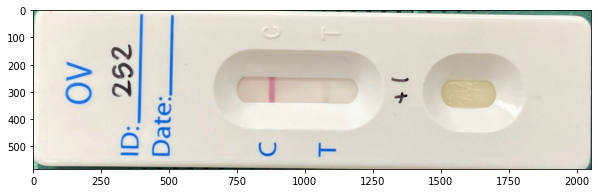

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
        
# Hide grid lines
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)
    
im=cv2.imread(list(res_df.path_crop)[0])
plt.imshow(im)
plt.show()